# Instrumental Variables

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

1. Introdução ao Método de Variáveis Instrumentais
2. Regressão Linear Simples
3. Ampliando o Modelo de Regressão Linear
4. Endogeneidade
5. Primeio Estágio
6. Segundo Estágio
7. Álgebra Matricial
8. Outros Métodos Relacionados
9. Considerações Finais



### Referências

* Acemoglu, Daron, Simon Johnson, and James A. Robinson. 2001. *"The Colonial Origins of Comparative Development: An Empirical Investigation."* American Economic Review 91 (5): 1369–1401. DOI: 10.1257/aer.91.5.1369 (https://www.aeaweb.org/articles?id=10.1257/aer.91.5.1369)
*
*


### 1. Introdução ao Método de Variáveis Instrumentais

Vamos reforçar alguns conceitos importantes vistos nas últimas aulas.

**Endogeneidade** ocorre em modelos de regressão quando pelo menos uma variável explicativa está correlacionada com o termo de erro. Isso viola a suposição de exogeneidade e leva a estimadores viesados e inconsistentes. Existem várias causas para a endogeneidade, incluindo:

* ***Omitted variable bias*** (OVB): é um conceito geral (problema de modelagem), que se aplica a qualquer *modelo estatístico mal especificado* (sintoma estatístico).
* ***Confounding variables***: é um conceito específico da *inferência causal* (estrutural e causal), que trata da validade do efeito estimado (diagnóstico causal). Ou seja, está ligado à distribuição não aleatória do tratamento.
    * ***Toda confounding variable não controlada gera um Omitted Variable Bias (OVB), mas nem toda variável omitida (causadora de OVB) é uma confounding variable.***

* ***Selection bias***: é *estrutural*, ligado à forma como a amostra é observada ou construída. 
  * ***Selection bias (amostral)***: desbalanceamento na construção da amostra;
  * ***Selection bias (*collider*)***: adicionar variável colisora.

* **Outras**:
  * ***Viés de Simultaneidade***: ocorre quando uma ou mais variáveis independentes são determinadas simultaneamente com a variável dependente — ou seja, há causalidade bidirecional entre elas. Isso gera uma violação da exogeneidade, pois essas variáveis tornam-se correlacionadas com o erro do modelo, resultando em estimativas viesadas e inconsistentes.
  * ***Erro de Medida***: ocorre quando uma variável explicativa não é observada com precisão, sendo substituída por uma medida com erro (aleatório ou sistemático). Esse problema também pode induzir endogeneidade, pois o erro de medida introduz correlação entre a variável observada e o erro do modelo, levando a estimativas viesadas e inconsistentes dos parâmetros.



Através das ***DAGs (Directed Acyclic Graphs)***, podemos mapear as relações entre as variáveis, identificar potenciais fontes de endogeneidade, e propor estratégias de estimação. Em resumo, vimos que:


<div style="text-align:center;">
    <img src="images\DAG38.png"  alt="Imagem" style="width: 500px;"/>
</div>


Na figura temos duas fontes de endogeneidade derivadas do *Confounding Bias*:

* **Seleção em Observáveis (Selection on Observables)**: A seleção em observáveis refere-se à situação em que a seleção das unidades para um tratamento ($D$) é influenciada por variáveis observáveis ($Z$). Em outras palavras, as características ou atributos conhecidos das unidades afetam a probabilidade de serem selecionadas para receber o tratamento. Nesse cenário, ***é possível controlar o viés resultante ao levar em consideração e ajustar as diferenças nas características observáveis entre os grupos de tratamento e controle***. Em outras palavras, os componentes observáveis influenciam a seleção para o tratamento (auto-seleção) e o resultado ($Y$).

* **Seleção em Não-Observáveis (Selection on Unobservables):** A seleção em não-observáveis ocorre quando a seleção das unidades para o tratamento é influenciada por variáveis não observadas que não estão disponíveis para o pesquisador. Essas variáveis não observadas podem estar correlacionadas tanto com a seleção para o tratamento quanto com o resultado, levando a um viés não observável. Em outras palavras, algum(s) componente(s) do termo não observado ($U$) influencia tanto a seleção para o tratamento (auto-seleção) quanto o resultado ($Y$). Nesse cenário, não é possível controlar o viés resultante, mesmo que todas as variáveis observáveis sejam levadas em consideração e ajustadas.

Essas duas fontes de endogeneidade geram a quebra da hipótese de **ignorabilidade** (ou **independência condicional**), que é uma suposição fundamental para a validade de inferências causais em modelos de regressão. A ignorabilidade implica que, dado um conjunto de variáveis observáveis, a seleção para o tratamento é independente do resultado potencial. Quando essa suposição não é atendida, as estimativas dos efeitos do tratamento podem ser enviesadas e não confiáveis.

$$ Y_i(0), Y_i(1) \perp D_i | X_i $$

Assim, conseguimos identificar o efeito causal com modelos que controlam a seleção em observáveis, como regressão linear com covariáveis, *propensity score matching* (PSM) e *inverse probability weighting* (IPW). Esses métodos ajustam as diferenças nas características observáveis entre os grupos de tratamento e controle, permitindo estimar o efeito causal do tratamento.

Relembrando outro exemplo:

<div style="text-align:center;">
    <img src="images\DAG1.png"  alt="Imagem" style="width: 500px;"/>
</div>


Aqui, vimos que além de controlar a possível seleção em observáveis fechando o caminho de porta dos fundos ("backdoor path"), também podemos controlar a seleção em não observáveis, ao utilizar variáveis instrumentais. 

No exemplo da segunda imagem, a variável $C$ é um bom candidato a variável instrumental, pois ela afeta a variável de tratamento $D$ e não afeta diretamente o resultado $Y$. Assim, podemos usar $C$ como um instrumento para estimar o efeito causal do tratamento $D$ sobre o resultado $Y$. $C$ apresenta duas características importantes:

* $C$ é correlacionada com $D$ (força/relevância do instrumento);
* $C$ não é correlacionada com o erro do modelo (exogeneidade do instrumento/Validade).


A conclusão de Judea Pearl, considerando os pressupostos das DAGs, é que para identificar o efeito causal de $D$ sobre $Y$, podemos utilizar (i) um sistema de equações simultâneas, (ii) controle de covariáveis, ou (iii) variáveis instrumentais.

Vamos relembrar como aplicar os métodos de *Instrumental Variables - IV* e de *Two Stage Least Squares - 2SLS* com dados de um artigo clássico de Acemoglu, Johnson e Robinson (2001). Eles receberam o Prêmio Nobel de Economia em 2021 por suas contribuições à economia política e ao estudo das instituições. O artigo é um marco na literatura sobre o impacto das instituições no desenvolvimento econômico e é amplamente citado em estudos de economia do desenvolvimento.


### 2. Regressão Linear Simples



O artigo ***"The Colonial Origins of Comparative Development: An Empirical Investigation"*** de Daron Acemoglu, Simon Johnson e James A. Robinson (2001) tem como principal objetivo investigar empiricamente a influência das instituições na explicação das diferenças de desenvolvimento econômico entre países. A grande contribuição do artigo é usar a mortalidade de colonizadores europeus como um instrumento para identificar o efeito causal das instituições sobre a renda per capita atual.

* Acemoglu, Daron, Simon Johnson, and James A. Robinson. 2001. *"The Colonial Origins of Comparative Development: An Empirical Investigation."* American Economic Review 91 (5): 1369–1401. DOI: 10.1257/aer.91.5.1369 (https://www.aeaweb.org/articles?id=10.1257/aer.91.5.1369)

<div style="text-align:center;">
    <img src="images\AJR2002_AER.png"  alt="Imagem" style="width: 650px;"/>
</div>


<div style="text-align:center;">
    <img src="images\AJR2002.png"  alt="Imagem" style="width: 650px;"/>
</div>


A tese dos autores é que:

* Durante o período colonial, os europeus adotaram diferentes estratégias de colonização dependendo das condições locais.

* Em locais onde a mortalidade dos colonizadores europeus era alta (por exemplo, devido a doenças tropicais como malária e febre amarela), eles não se estabeleceram de forma permanente e criaram instituições extrativas — ou seja, voltadas à exploração econômica sem preocupação com direitos de propriedade, democracia ou incentivos ao investimento local.

* Já em locais com baixa mortalidade europeia, os colonizadores se estabeleceram com suas famílias e construíram instituições mais inclusivas, como sistemas legais confiáveis e direitos de propriedade bem definidos.

Essas instituições, segundo os autores, persistiram ao longo do tempo e têm efeitos duradouros sobre o desempenho econômico atual dos países.


**Estrutura de Identificação**

O modelo pode ser resumido por uma estratégia de variáveis instrumentais (IV), onde:

- **Instituições atuais** são a variável endógena,
  -  Índice de Proteção contra Expropriação de Investimentos (Protection Against Risk of Expropriation), varia de 0 a 10, onde valores mais altos indicam maior proteção contra expropriação por parte do governo (i.e., maior segurança dos direitos de propriedade).
  -  Fonte: Political Risk Services – International Country Risk Guide (ICRG)
  -  Período considerado: Média dos anos de 1985 a 1995.
  -  Os autores argumentam que a proteção contra expropriação capta um “cluster de instituições” que são fundamentais para o desenvolvimento:
     -  *“Our view is that there is a ‘cluster of institutions,’ including constraints on government expropriation, independent judiciary, property rights enforcement, and institutions providing equal access to education and ensuring civil liberties, that are important to encourage investment and growth.”*
  - Ou seja, embora o índice seja focado na proteção contra expropriação, ele é considerado um bom proxy para a qualidade institucional mais ampla.
- **Renda per capita atual** é a variável dependente,
  - PIB per capita em paridade de poder de compra (PPP) no ano de 1995 (em dólares de 1995).
  - PPP para refletir melhor o poder de compra real da população em cada país
- **Mortalidade de colonizadores (settler mortality)** atua como instrumento exógeno.
  - número de mortes por mil por ano entre europeus enviados para as colônias
  - Essa medida é interpretada como exógena ao desenvolvimento atual, mas associada às estratégias coloniais adotadas: 
    - Mortalidade era alta: europeus não se estabeleciam com famílias, optando por criar instituições extrativistas, voltadas à exploração dos recursos com pouca preocupação com o bem-estar local. 
    - Mortalidade era baixa: eles colonizavam permanentemente, levando a instituições mais inclusivas e voltadas ao crescimento de longo prazo.


***Modelagem em DAG***

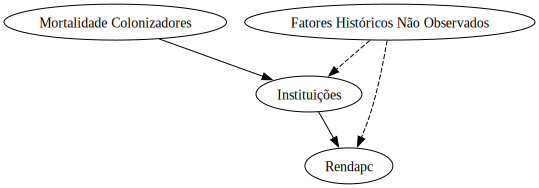

In [8]:
import graphviz as gr
g = gr.Digraph()
# Relação causal de interesse
g.edge("Instituições", "Rendapc")
# Confounding não observável
g.edge("Fatores Históricos Não Observados", "Instituições", style="dashed")
g.edge("Fatores Históricos Não Observados", "Rendapc", style="dashed")
# Instrumento
g.edge("Mortalidade Colonizadores", "Instituições")
g

Modelagem econométrica:

Primeiro Estágio:
$$
\text{Instituições}_i = \alpha + \gamma \cdot \text{Mortalidade}_i + u_i
$$

Segundo Estágio:
$$
\text{Rendapc}_i = \beta + \delta \cdot \widehat{\text{Instituições}}_i + \varepsilon_i
$$

Essa abordagem visa lidar com **confounding por não-observáveis históricos** que possam afetar simultaneamente instituições e desenvolvimento econômico, como cultura, geografia ou legado colonial.



Vamos aprofundar a análise tem termos econométricos em python.

Primeiro, vamos carregar os dados e analisá-los.

***Pacotes***

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

***Ajuste dos gráficos***

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') 
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

**Carregando os dados**

In [11]:
# Dados - Acemoglu, Johnson, Robinson 2001
df = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/AJR02.csv', index_col=0)
df

,GDP,Exprop,Mort,Latitude,Neo,Africa,Asia,Namer,Samer,logMort,Latitude2
1,8.39,6.50,78.20,0.3111,0,1,0,0,0,4.359270,0.096783
2,7.77,5.36,280.00,0.1367,0,1,0,0,0,5.634790,0.018687
3,9.13,6.39,68.90,0.3778,0,0,0,0,1,4.232656,0.142733
4,9.90,9.32,8.55,0.3000,1,0,0,0,0,2.145931,0.090000
5,9.29,7.50,85.00,0.2683,0,0,0,1,0,4.442651,0.071985
...,...,...,...,...,...,...,...,...,...,...,...
60,9.03,7.00,71.00,0.3667,0,0,0,0,1,4.262680,0.134469
61,10.22,10.00,15.00,0.4222,1,0,0,1,0,2.708050,0.178253
62,9.07,7.14,78.10,0.0889,0,0,0,0,1,4.357990,0.007903
63,7.28,6.41,140.00,0.1778,0,0,1,0,0,4.941642,0.031613


Mostrar as estatísticas descritivas 

In [12]:
df.describe()

,GDP,Exprop,Mort,Latitude,Neo,Africa,Asia,Namer,Samer,logMort,Latitude2
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,8.062500,6.516094,245.911094,0.190483,0.062500,0.421875,0.140625,0.218750,0.171875,4.646749,0.057002
std,1.043701,1.468841,472.623943,0.145075,0.243975,0.497763,0.350382,0.416667,0.380254,1.252543,0.086039
min,6.110000,3.500000,8.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.145931,0.000000
25%,7.302500,5.617500,68.900000,0.088900,0.000000,0.000000,0.000000,0.000000,0.000000,4.232656,0.007903
50%,7.950000,6.475000,78.150000,0.161150,0.000000,0.000000,0.000000,0.000000,0.000000,4.358630,0.026000
75%,8.852500,7.352500,240.000000,0.267100,0.000000,1.000000,0.000000,0.000000,0.000000,5.480639,0.071343
max,10.220000,10.000000,2940.000000,0.666700,1.000000,1.000000,1.000000,1.000000,1.000000,7.986165,0.444489


Vamos usar um gráfico de dispersão para ver se existe alguma relação óbvia entre o GDP e a proteção contra a expropriação.

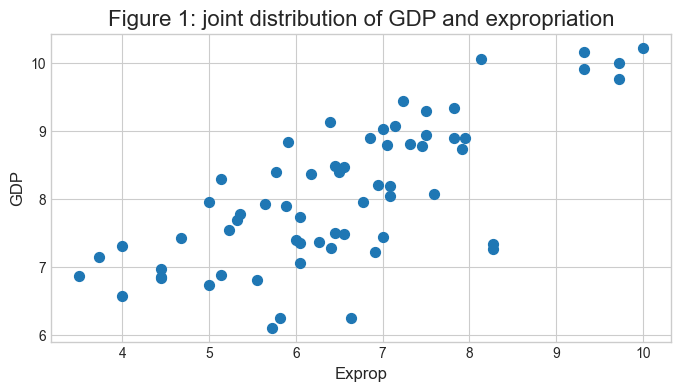

In [13]:
# Plotar relacionamento entre GDP e taxa de expropriação
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 1: joint distribution of GDP and expropriation')
df.plot(x='Exprop', y='GDP', kind='scatter', s=50, ax=ax);

O gráfico mostra uma relação positiva bastante forte entre a proteção contra a expropriação ("Instituições") e o logaritmo do PIB per capita. **Então melhores instituições parecem estar positivamente correlacionadas com melhores resultados econômicos** (maior PIB per capita).

Dado o enredo, escolher um modelo linear para descrever essa relação parece uma suposição razoável.

Podemos escrever nosso modelo como:

$$ GDP_{i} = \beta_0 + \beta_1 Exprop_i + u_i $$

onde:
* $GDP_{i}$ é o logaritmo do PIB per capita PPP do país $i$ em 1995
* $\beta_0$ é o intercepto do modelo
* $\beta_1$ é a inclinação da linha de regressão, representando o efeito marginal da proteção contra a expropriação no PIB per capita
* $u_i$ é o erro do modelo, que captura a variação no PIB per capita que não pode ser explicada pela proteção contra a expropriação.

A técnica mais comum para estimar os parâmetros ($\beta$'s) do modelo linear é Mínimos Quadrados Ordinários (MQO).

Como o nome indica, um modelo OLS/MQO é resolvido encontrando os parâmetros que minimizam a soma dos resíduos quadrados , ou seja:

$$ \hat{\beta} = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} (\hat{u}_i)^2 = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} (GDP_i - \hat{GDP}_i)^2 $$

Lembre que para estimar a constante devemos adicionar uma coluna de 1s à matriz de variáveis independentes.

Agora, podemos construir nosso modelo `statsmodels` usando a função OLS.

In [14]:
# Regressão GDP sobre Expropriation Rate
reg1 = sm.OLS.from_formula('GDP ~ Exprop', df)
type(reg1)

statsmodels.regression.linear_model.OLS

Precisamos usar `.fit()` para obter estimativas de parâmetros

In [15]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

Agora temos o modelo de regressão ajustado armazenado em results.

Para visualizar os resultados da regressão OLS/MQO, podemos chamar o método `.summary()`.

Observe que uma observação foi erroneamente excluída dos resultados do artigo original (veja a nota localizada em maketable2.do da página de Acemoglu) e, portanto, os coeficientes diferem

In [16]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDP   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     72.71
Date:                qua, 07 mai 2025   Prob (F-statistic):           4.84e-12
Time:                        13:31:08   Log-Likelihood:                -68.214
No. Observations:                  64   AIC:                             140.4
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6609      0.409     11.402      0.000       3.844       5.478
Exprop         0.5220      0.061      8.527      0.000       0.400       0.644
==============================================================================
Omnibus:                        7.134   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.698
Skew:                          -0.784   Prob(JB):                       0.0351
Kurtosis:                       3.234   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OBS: há um problema nos dados. uma observação foi erroneamente excluída dos resultados do artigo original e, portanto, os coeficientes diferem ligeiramente.

Usando nossas estimativas de parâmetros, agora podemos escrever nossa relação estimada como:

$$ \hat{GDP}_{i} = 4.63 + 0.53 Exprop_i $$

Esta equação descreve a linha que melhor se ajusta aos nossos dados, conforme mostrado na Figura 2.

Podemos usar essa equação para "prever" o nível do logaritmo do PIB per capita para um valor do índice de proteção contra expropriação.

In [18]:
mean_expr = np.mean(df['Exprop'])
mean_expr

6.5160937500000005

In [19]:
predicted_logpdp95 = results.params[0] + results.params[1] * mean_expr
predicted_logpdp95

8.062499999999995

Ou seja, para um país com um valor de índice institucional de **6,51** (a média do conjunto de dados), descobrimos que seu nível previsto de logaritmo do PIB per capita em 1995 é **8,09**.

Uma maneira mais fácil (e precisa) de obter esse resultado é usar `.predict()` e definir 
e

In [ ]:
mean_expr = df['Exprop'].mean()
new_data = pd.DataFrame({'Exprop': [mean_expr]})
results.predict(new_data)

0    8.0625
dtype: float64

Podemos obter uma matriz de previsões $GDP_{i}$ para cada valor de $Exprop_i$ em nosso conjunto de dados, recorrendo `.predict()` aos nossos resultados.

Traçando os valores previstos em relação $Exprop_i$, mostra que os valores previstos estão ao longo da linha linear que ajustamos acima.

Os valores observados de $GDP_{i}$ também são plotados para fins de comparação.

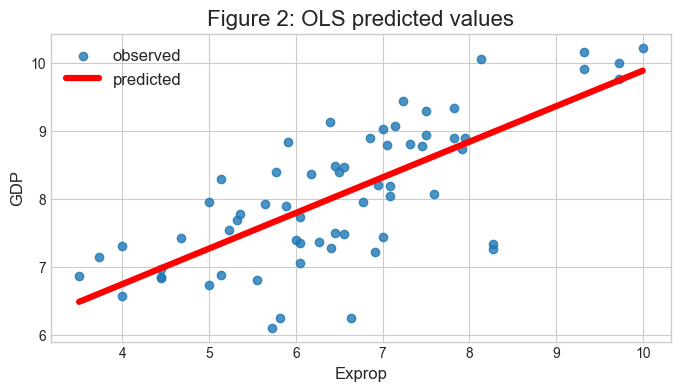

In [21]:
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 2: OLS predicted values')

# Drop missing observations from whole sample
df_plot = df.dropna(subset=['GDP', 'Exprop'])
sns.regplot(x=df_plot['Exprop'], y=df_plot['GDP'], ax=ax, order=1, ci=None, line_kws={'color':'r'})

ax.legend(['observed', 'predicted'])
ax.set_xlabel('Exprop')
ax.set_ylabel('GDP')
plt.show()

### 3. Ampliando o Modelo de Regressão Linear

Até agora, contabilizamos apenas as instituições que afetam o desempenho econômico. É quase certo que há vários outros fatores que afetam o PIB e que não estão incluídos em nosso modelo.

Deixando de fora as variáveis ​​que afetam $GDP_{i}$ resultará em **viés de variável omitida**, produzindo estimativas de parâmetros tendenciosas e inconsistentes.

Podemos estender nosso modelo de regressão bivariada para um modelo de regressão multivariada adicionando outros fatores que podem afetar $GDP_{i}$.

[AJR01] considere outros fatores como:

* o efeito do clima nos resultados económicos; a latitude é usada como proxy para isso
* diferenças que afetam tanto o desempenho econômico quanto as instituições, por exemplo, culturais, históricas, etc.; tentar controlar com o uso de modelos continentais

Vamos estimar alguns dos modelos estendidos considerados no artigo (Tabela 2)

In [22]:
# Adicionar constante
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df['GDP'], X1, missing='drop').fit()
reg2 = sm.OLS(df['GDP'], X2, missing='drop').fit()
reg3 = sm.OLS(df['GDP'], X3, missing='drop').fit()

Agora que ajustamos nosso modelo, usaremos `summary_col` para exibir os resultados em uma única tabela (os números do modelo correspondem aos do artigo)

In [23]:
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const','Exprop','Latitude','Latitude2'])
results_table

,Model 1,Model 2,Model 3
const,4.66***,4.55***,5.95***
,(0.41),(0.45),(0.68)
Exprop,0.52***,0.49***,0.40***
,(0.06),(0.07),(0.06)
Latitude,,2.16,0.42
,,(1.68),(1.47)
Latitude2,,-2.12,0.44
,,(2.86),(2.48)
Africa,,,-1.06**
,,,(0.41)


### 4. Endogeneidade

Conforme discutido por [AJR01], os modelos estimados por Mínimos Quadrados Ordinários (MQO/OLS) sofrem potencialmente de **problemas de endogeneidade**, resultando em estimativas viesadas e inconsistentes.

Os autores utilizam a estratégia de **variáveis instrumentais (IV)** principalmente para lidar com **viés de variável omitida**, ou seja, *confounding* devido a fatores **não observáveis**.

> A preocupação central é que as **instituições contemporâneas** (como o grau de proteção aos direitos de propriedade) podem estar correlacionadas com **fatores históricos, culturais ou geográficos não observáveis**, os quais também influenciam o desempenho econômico atual. Isso gera endogeneidade no modelo e compromete a interpretação causal de uma regressão simples entre instituições e desenvolvimento.

Algumas fontes possíveis dessa endogeneidade incluem:

- Países mais ricos podem ter maior capacidade (ou preferência) por adotar instituições melhores;
- Fatores que afetam a renda também podem estar correlacionados com a qualidade institucional;
- A própria construção do índice de instituições pode conter viés: analistas podem avaliar de forma mais favorável países mais ricos.

Para lidar com esse problema, os autores utilizam o método de **Instrumental Variables (IV)**, que envolve a utilização de uma variável instrumental para isolar a variação exógena na variável endógena (neste caso, as instituições). O estimador é conhecido como **Two-Stage Least Squares (2SLS)**, ou **Mínimos Quadrados em Dois Estágios (2SLS)**, o qual pode ser entendido como uma extensão da regressão MQO que permite isolar a variação exógena de uma variável endógena.

Essa abordagem exige um **instrumento válido** e **relevante** para a variável endógena, ou seja, uma variável que:

1. Seja **exógena**: Não seja correlacionada com o termo de erro $ u_i $ (exogeneidade, validade do instrumento).
   * $\text{Cov}(Z_i, u_i) = 0$ (não correlacionada com o erro do modelo);
2. Seja **correlacionada com $Exprop_i$** (primeiro estágio); ***NÃO afete diretamente*** $GDP_i$ ($Y$),
   * $\text{Cov}(Z_i, Exprop_i) \neq 0$ (correlacionada com a variável endógena);


**Modelagem**

***Segundo Estágio (equação estrutural - o que queremos estimar):***

$$
GDP_{i} = \beta_0 + \beta_1 \cdot Exprop_i + u_i
$$

**Primeiro Estágio (instrumentação):**
$$
Exprop_i = \pi_0 + \pi_1 \cdot \log(Mortality_i) + v_i
$$

Neste contexto, $ Z_{i} = \log(Mortality_i) $ — a mortalidade de colonizadores europeus — é usada como **instrumento para a variável endógena $ Exprop_i $** (índice de proteção contra expropriação - Medida de nível Institucional).

A principal contribuição de [AJR01] é justamente a utilização de **taxas históricas de mortalidade de colonizadores** como instrumento para a qualidade institucional.

> A hipótese dos autores é que altas taxas de mortalidade levaram à instalação de **instituições extrativas** (com baixa proteção à propriedade), enquanto baixas taxas favoreceram **instituições inclusivas**. Essas instituições persistiram ao longo do tempo e influenciam o desempenho econômico atual.


Vejamos se há uma relação gráfica entre a mortalidade e o índice de proteção contra a expropriação.

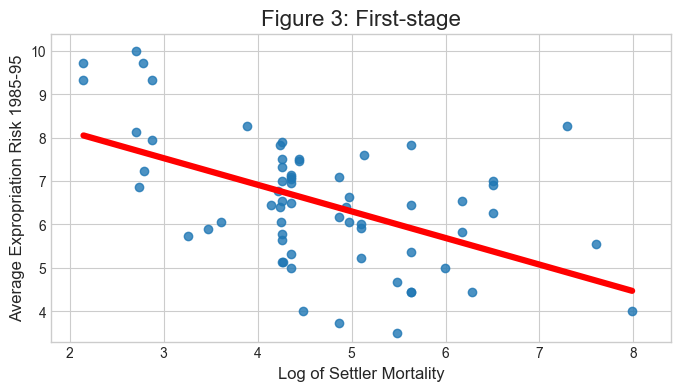

In [ ]:
X = df['logMort']
y = df['Exprop']

# Init figure
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 3: First-stage')
# Fit a linear trend line
sns.regplot(x=X, y=y, ax=ax, order=1, scatter=True, ci=None, line_kws={"color": "r"})
ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Average Expropriation Risk 1985-95');

***Possível crítica ao instrumento***

* A segunda condição pode não ser satisfeita se as taxas de mortalidade dos colonos nos séculos XVII a XIX tiverem um efeito direto no PIB atual (além de seu efeito indireto por meio de instituições).
  * Por exemplo, as taxas de mortalidade de colonos podem estar relacionadas ao ambiente atual de doenças em um país, o que pode afetar o desempenho econômico atual.

Os autores argumentam que isso é improvável porque:

* A maioria das mortes de colonos foi causada por malária e febre amarela e teve efeito limitado sobre a população local. A carga de doenças sobre populações locais na África ou na Índia, por exemplo, não pareceu ser maior que a média, apoiada por densidades populacionais relativamente altas nessas áreas antes da colonização.

Assim, parece que temos um instrumento válido. Logo, podemos usar a regressão 2SLS para obter estimativas de parâmetros não viesados, e consistentes.

### 5. Primeio Estágio

Vamos trabalhar as duas etapas do estimador 2SLS.

A primeira etapa envolve a regressão da variável endógena ($Exprop_i$) no instrumento.

Tecnicamente, a matriz $Z_{i}$ é composta por todas as variáveis exógenas em nosso modelo, incluindo o instrumento e outras variáveis que não são endógenas. Portanto, a matriz $Z_{i}$ é a matriz de variáveis instrumentais (IV) e variáveis exógenas (X).

Entretanto, no caso desse exemplo, nossa matriz instrumental ($Z_{i}$) é simplesmente uma constante na primeira coluna e a taxas de mortalidade de colonos $logMort_i$ na segunda coluna.

Portanto, estimaremos a regressão do primeiro estágio como:

$$ Exprop_i = \pi_0 + \pi_1 logMort_{i} + v_i $$





In [25]:
# First stage
results_fs = sm.OLS.from_formula('Exprop ~ logMort', df).fit()
results_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exprop   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     23.34
Date:                qua, 07 mai 2025   Prob (F-statistic):           9.27e-06
Time:                        13:31:49   Log-Likelihood:                -104.69
No. Observations:                  64   AIC:                             213.4
Df Residuals:                      62   BIC:                             217.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3659      0.611     15.339      0.000       8.145      10.586
logMort       -0.6133      0.127     -4.831      0.000      -0.867      -0.360
==============================================================================
Omnibus:                        0.047   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.977   Jarque-Bera (JB):                0.154
Skew:                           0.060   Prob(JB):                        0.926
Kurtosis:                       2.792   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***E o instrumento é forte?***

Para testar isso, fazemos o **Teste F sobre os intrumentos excluídos** (no primeiro estágio da regressão).

In [27]:
print(results_fs.f_test(['logMort']))

<F test: F=23.341328052062696, p=9.272862612030776e-06, df_denom=62, df_num=1>


Consideramos os instrumentos fortes porque cumpre a "regra de dedo" (F>10).


***E a validade do instrumento?***

No caso de apenas um único instrumento (exatamente identificado), não há teste estatístico para a validade do instrumento. A validade deve ser discutida com base em argumentos teóricos (argumentativos). Para o caso de mais de um instrumento, podemos usar o teste de sobreidentificação de Sargan-Hansen (ver mais adiante).

### 6. Segundo Estágio


Precisamos recuperar os valores previstos de primeiro estágio usando o `.predict()`. Posteriormente, esses valores previstos serão usados como a variável endógena em nosso segundo estágio. 

Ou seja, substituímos então a variável endógena $Exprop_i$ pelos valores previstos $\hat{Exprop}_i$ no modelo linear estrutural.

Nossa regressão de segundo estágio é assim definida:

$$ GDP_{i} = \beta_0 + \beta_1 \hat{Exprop}_i + u_i $$



In [26]:
df['predicted_Exprop'] = results_fs.predict()

# Second stage
results_ss = sm.OLS.from_formula('GDP ~ predicted_Exprop', df).fit()

# Print
results_ss.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDP   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     53.24
Date:                qua, 07 mai 2025   Prob (F-statistic):           6.58e-10
Time:                        13:31:52   Log-Likelihood:                -73.208
No. Observations:                  64   AIC:                             150.4
Df Residuals:                      62   BIC:                             154.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0448      0.830      2.463      0.017       0.385       3.705
predicted_Exprop     0.9235      0.127      7.297      0.000       0.671       1.177
==============================================================================
Omnibus:                       10.463   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.693
Skew:                          -0.806   Prob(JB):                      0.00476
Kurtosis:                       4.188   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Os resultados da regressão do segundo estágio nos fornecem uma estimativa não viesada e consistente do efeito das instituições nos resultados econômicos.

O resultado sugere uma relação positiva mais forte do que os resultados do OLS indicaram.

Observe que, embora nossas estimativas de parâmetros estejam corretas, nossos erros padrão não estão e, por esse motivo, não é recomendado calcular 2SLS 'manualmente' (em etapas com OLS).

Podemos estimar corretamente uma regressão 2SLS em uma etapa usando o pacote `linearmodels` , uma extensão do `statsmodels`

Observe que ao usar IV2SLS, as variáveis ​​exógenas e de instrumento são divididas nos argumentos da função (enquanto antes o instrumento incluía variáveis ​​exógenas)

In [65]:
# IV regression
iv = IV2SLS(dependent=df['GDP'], exog=df['const'], endog=df['Exprop'], instruments=df['logMort']).fit()
# Print
iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.2205
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2079
No. Observations:                  64   F-statistic:                    29.811
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        10:57:24   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.0448     1.1273     1.8139     0.0697     -0.1647      4.2542
Exprop         0.9235     0.1691     5.4599     0.0000      0.5920      1.2550
==============================================================================

Endogenous: Exprop
Instruments: logMort
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [68]:
# IV regression
iv2 = IV2SLS.from_formula('GDP ~ 1 + [Exprop ~ logMort]', df).fit()
# Print
iv2

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.2205
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2079
No. Observations:                  64   F-statistic:                    29.811
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        10:58:25   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2.0448     1.1273     1.8139     0.0697     -0.1647      4.2542
Exprop         0.9235     0.1691     5.4599     0.0000      0.5920      1.2550
==============================================================================

Endogenous: Exprop
Instruments: logMort
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x1d020dd3d90

Dado que agora temos estimativas consistentes e não viesadas, podemos inferir do modelo que estimamos que as diferenças institucionais (decorrentes de instituições criadas durante a colonização) podem ajudar a explicar as diferenças nos níveis de renda entre os países atualmente.

### 7. Álgebra Matricial



O parâmetro $\beta$ OLS também pode ser estimado usando álgebra matricial e `numpy`.

A equação linear que queremos estimar é (escrita em forma de matriz)

$$ y = X \beta + u $$


In [30]:
# Algebra do OLS
X = df[['const', 'Exprop']].values
Z = df[['const', 'logMort']].values
y = df['GDP'].values

Para resolver o parâmetro desconhecido $\beta$, queremos minimizar a soma dos resíduos quadrados

$$ \hat{\beta} = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} \hat{\epsilon}`\hat{\epsilon}$$


Reorganizando a primeira equação e substituindo na segunda equação, podemos escrever $\beta$ 

$$ \hat{\beta} = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} (y - X\beta)^{´}(y - X\beta) $$

A resolução deste problema de otimização fornece a solução para o $\beta$ OLS como:

$$ \hat{\beta} = (X^{´}X)^{-1}X^{´}y $$



In [31]:
# Computar o beta OLS
beta_OLS = inv(X.T @ X) @ X.T @ y

print(beta_OLS)

[4.66087966 0.52203367]


Como vimos acima, o coeficiente MQO pode sofrer de viés de endogeneidade. 

A solução vista é através da instrumentalização da taxa média de expropriação prevista com a mortalidade média dos colonos.

Se definirmos a mortalidade dos colonos como coluna da matriz de variáveis exógenas $Z$, nosso modelo completo é

Defina $Z$ como matriz de instrumentos (com $L$ colunas):

$$ Z = [\mathbf{1}, Z_2] $$

onde $Z_2$ inclui, por exemplo, a mortalidade dos colonos.

Projete $X$ sobre os instrumentos $Z$:

$$ \hat{X} = P_Z X = Z (Z'Z)^{-1} Z' X $$

Essa é a parte de $X$ que pode ser explicada por instrumentos exógenos.


Use $\hat{X}$ na equação da regressão para estimar $\beta$ via OLS:

$$ \hat{\beta}_{2SLS} = (\hat{X}'\hat{X})^{-1} \hat{X}' y $$

Substituindo $\hat{X}$:

$$ \hat{\beta}_{2SLS} = (X'Z(Z'Z)^{-1}Z'X)^{-1} X'Z(Z'Z)^{-1}Z'y $$

In [ ]:
# computar beta 2SLS
beta_2SLS = inv(X.T @ Z @ inv(Z.T @ Z) @ Z.T @ X) @ X.T @ Z @ inv(Z.T @ Z) @ Z.T @ y
print(beta_2SLS)

[2.0447613  0.92351936]


***E se nós utilizásemos o termo ao quadrado da mortalidade dos colonos como um outro instrumento?***

Vejamos graficamente se essa ideia faz sentido.

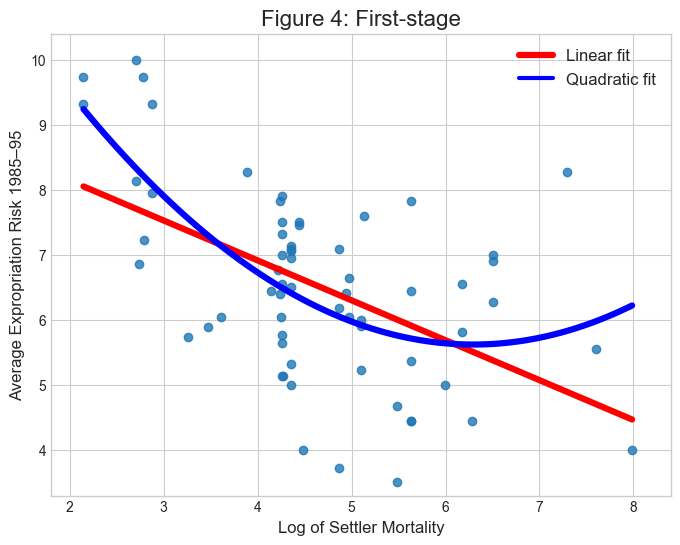

In [33]:
X = df['logMort']
y = df['Exprop']

# Criar gráfico
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Figure 4: First-stage')

# Regressão linear (reta)
sns.regplot(x=X, y=y, ax=ax, order=1, scatter=True, ci=None, line_kws={"color": "red", "label": "Linear fit"})

# Regressão quadrática (curva)
sns.regplot(x=X, y=y, ax=ax, order=2, scatter=False, ci=None, line_kws={"color": "blue"})

# Adiciona manualmente a legenda da curva quadrática
ax.plot([], [], color='blue', label='Quadratic fit')

# Configurações finais
ax.set_xlim([1.8, 8.4])
ax.set_ylim([3.3, 10.4])
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Average Expropriation Risk 1985–95')
ax.legend()
plt.show()

Vamos assumir que a mortalidade dos colonos é uma variável exógena e que o termo ao quadrado da mortalidade dos colonos é um bom instrumento para a variável endógena $Exprop_i$.

A possivel explicação para isso é que a mortalidade dos colonos pode afetar a qualidade das instituições de forma não linear, ou seja, o efeito da mortalidade dos colonos sobre as instituições pode aumentar à medida que a mortalidade aumenta.

In [34]:
df['logMort_2'] = df['logMort']**2

Agora a temos mais instrumentos que variáveis endógenas, o que nos leva a um modelo de **Mínimos Quadrados em Dois Estágios com Múltiplos Instrumentos**. E dizemos que temos um modelo **sobreidentificado** (*overidentified*).

Vamos ver como isso funciona na prática.


In [37]:
# IV regression - formula
iv3 = IV2SLS.from_formula('GDP ~ 1 + [Exprop ~ logMort + logMort_2]', df).fit()
# Print
iv3

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.4244
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4151
No. Observations:                  64   F-statistic:                    62.728
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        13:59:54   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.0882     0.6543     4.7199     0.0000      1.8058      4.3706
Exprop         0.7634     0.0964     7.9201     0.0000      0.5745      0.9523
==============================================================================

Endogenous: Exprop
Instruments: logMort, logMort_2
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x1412d45afd0

Algebricamente

In [39]:
X = df[['const', 'Exprop']].values
y = df['GDP'].values

# Definir nossa nova matriz Z sobreidentificada
Z = df[['const', 'logMort', 'logMort_2']].values

# Primeiro estágio: projetar X nos instrumentos Z
ZTZ_inv = np.linalg.inv(Z.T @ Z)
PZ = Z @ ZTZ_inv @ Z.T   # matriz de projeção P_Z

# Segundo estágio: usar a parte exógena de X para estimar beta
beta_2sls = np.linalg.inv(X.T @ PZ @ X) @ (X.T @ PZ @ y)

print(beta_2sls)

[3.08817432 0.76339075]


Existe uma forma de fazer em apenas uma etapa, mas não é tão simples quanto a forma de duas etapas.

In [41]:
beta_2SLS = inv(X.T @ Z @ inv(Z.T @ Z) @ Z.T @ X) @ (X.T @ Z @ inv(Z.T @ Z) @ Z.T @ y)
print(beta_2SLS)

[3.08817432 0.76339075]


### 8. Outros Métodos Relacionados

Outros modelos aprofundaram a análise econométrica a fim de buscar eficiência dos estimadores a partir da possibilidade de uso de múltimpos instrumentos. Por exemplo:

* GMM (Generalized Method of Moments)
  * One-Step GMM
  * Two-Step GMM
* LIML (Limited Information Maximum Likelihood)

***Método Generalizado dos Momentos – GMM***

*Lars Peter Hansen (1982)*

O método GMM é uma generalização do método IV, que permite a utilização de mais instrumentos que o número de variáveis endógenas. 

Seja $Z$ o conjunto de variáveis exógenas $(nxL)$, onde $Z=[Z_{1} Z_{2}]$

* $Z_{1}$: instrumentos excluídos ($Z_{1}$), elas não estão incluídas diretamente como regressores no modelo estrutural, mas são assumidas como exógenas e correlacionadas com as variáveis endógenas.
  * $L_{1}$: número de instrumentos excluídos
* $Z_{2}$: ($Z-Z_{1}$) são os instrumentos incluídos - instrumentos incluídos, ou seja, variáveis exógenas que fazem parte dos regressores estruturais (normalmente chamadas de $X$)
  * $L_{2}$: número de instrumentos incluídos


**condição de identificação**: L maior ou igual a K

* L>k sobreidentificada
* L=k equação exatamente identificada.

**Hipótese GMM1** 

$$ E[Z_{i},u_{i}]=0 $$

A Hipótese GMM1 afirma que os instrumentos são não correlacionados com o termo de erro. Isto é, em média, não há relação sistemática entre os instrumentos e os fatores não observados que afetam a variável dependente.


E seja $g(.)$ uma função (linear ou não linear), então,

$$ g(\beta)= Z_{i}'u_{i} = Z_{i}´(Y-X_{i}\beta) $$

considerando a hipótese,

$$ E[g_{i}(\beta)]= E[Z_{i}´u_{i}]=0 $$

Considere a seguinte função objetivo:

$$ J(\hat{\beta})= n\hat{g}(\beta)´W\hat{g}(\beta) $$

O estimador GMM minimiza a função objetivo $J(\hat{\beta})$ em relação a $\beta$, onde $W$ é uma matriz de pesos simétrica positiva definida.

$$ \hat{\beta}_{GMM}= argmin_{\hat{\beta}} J(\hat{\beta}) = n\hat{g}(\beta)´W\hat{g}(\beta) = [Z´(Y-X\beta)]´W[Z´(Y-X\beta)]$$

$$ \hat{\beta}_{GMM} = [Z´(Y-X\beta)]´W[Z´(Y-X\beta)]$$


Derivando com relação a $\beta$, temos:

$$ \beta_{GMM}= (X´ZWZ´X)^{-1}X´ZWZ´Y $$

O estimador GMM é consistente para qualquer matriz $W$ simétrica positiva-definida. 

OBS: O estimador GMM lembra alguns estimadores que vimos anteriormente:

$$ \beta_{2SLS}= (X´Z(Z´Z)^{-1}Z´X)^{-1}X´Z(Z´Z)^{-1}Z´Y $$

$$ \beta_{GLS} = (X´\Omega^{-1}X)^{-1}X´\Omega^{-1}Y $$

Os $\hat{\beta_{GMM}}$ são assintoticamente normais, com matriz de variância-covariância dada por:

$$ V(\hat{\beta}_{GMM}) = (X´ZWZ´X)^{-1}X´ZW \hat{S} WZ´X(X´ZWZ´X)^{-1} $$

E uma estimativa do tipo robusta de White de S é dada por:

$$ \hat{S}= \frac{1}{n} \sum Z_{i}´\hat{u_{i}}\hat{u_{i}}´Z_{i} $$

Temos dois tipos de GMM:
* One-step GMM
* Two-step GMM

**One-step GMM**

$$ \hat{\beta}_{GMM}= (X´ZWZ´X)^{-1}X´ZWZ´Y $$

Assume-se que a matriz de pesos W é conhecida, e dada por $W = (Z´Z)^{-1}$, então o estimador torna-se o 2SLS:

$$ \hat{\beta}_{1SGMM} = \hat{\beta}_{2SLS} = (X´Z(Z´Z)^{-1}Z´X)^{-1}X´Z(Z´Z)^{-1}Z´Y $$

**Two-step GMM**

É o estimador GMM mais eficiente (com variância mínima), onde assume-se que $W=(\hat{S})^{-1}$, onde $\hat{S}$ é uma estimativa robusta de S. Então, o estimador GMM torna-se:

$$ \hat{\beta}_{2SGMM} = (X´Z\hat{S}Z´X)^{-1}X´Z\hat{S}Z´Y $$

$$ \hat{\beta}_{2SGMM} = (X´Z(Z´\Omega Z)Z´X)^{-1}X´Z(Z´\Omega Z)Z´Y $$

$$ \hat{\beta}_{2SGMM} = (X´Z(Z´uu´ Z)Z´X)^{-1}X´Z(Z´uu´ Z)Z´Y $$

É chamado de Two-step GMM porque no primeiro estágio obtem-se os resíduos por 2SLS e compor $\hat{S}$, e no segundo estágio utiliza-se $\hat{S}$ para obter o estimador GMM. Também é conhecido como **Feasible Efficient GMM estimator**.

In [42]:
# GMM
from linearmodels.iv import IVGMM
GMM1 = IVGMM.from_formula('GDP ~ 1 + [Exprop ~ logMort]', df).fit()
GMM1


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.2205
Estimator:                     IV-GMM   Adj. R-squared:                 0.2079
No. Observations:                  64   F-statistic:                    29.811
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        14:08:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2.0448     1.1273     1.8139     0.0697     -0.1647      4.2542
Exprop         0.9235     0.1691     5.4599     0.0000      0.5920      1.2550
==============================================================================

Endogenous: Exprop
Instruments: logMort
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
IVGMMResults, id: 0x1412fd42050

In [43]:
# Two step  GMM
GMM2 = IVGMM.from_formula('GDP ~ 1 + [Exprop ~ logMort + logMort_2]', df).fit()
GMM2

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.4655
Estimator:                     IV-GMM   Adj. R-squared:                 0.4569
No. Observations:                  64   F-statistic:                    67.394
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        14:09:47   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.4402     0.5899     5.8322     0.0000      2.2841      4.5963
Exprop         0.7143     0.0870     8.2094     0.0000      0.5438      0.8849
==============================================================================

Endogenous: Exprop
Instruments: logMort, logMort_2
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
IVGMMResults, id: 0x1412fd44b50

**Por que utilizamos GMM?**

* Se $X = Z$, então o estimador converge para o OLS (GMM -> OLS)
* Se o modelo é exatamente identificado, o GMM converve para o IV/2SLS (GMM -> 2SLS)
* Para modelos sobreidentificados, o GMM é assintoticamente eficiente, mas se os erros forem homocedásticos, o GMM -> 2SLS.
* Se há *heterocedasticidade*, o GMM é mais eficiente que o 2SLS!
* Em séries de tempo, com correlação serial no termo de erro, usar GMM é mais eficiente que 2SLS.
* É possível perceber fortemente os benefícios do GMM em modelos dinâmicos de dados em painel.

***LIML (Limited Information Maximum Likelihood)***

O estimador LIML é uma alternativa ao 2SLS no contexto de modelos com variáveis instrumentais. Ele é especialmente útil quando há mais de um instrumento (i.e., o modelo é sobreidentificado).

* O LIML tende a ser mais eficiente que o 2SLS em amostras pequenas, particularmente quando os instrumentos são fracos, ou seja, pouco correlacionados com as variáveis endógenas.
* Em termos assintóticos, o LIML é consistente e equivalente ao estimador GMM ótimo sob certas condições (como homocedasticidade).
* No entanto, o LIML é menos sensível à presença de instrumentos fracos do que o 2SLS, o que o torna mais robusto em certas situações práticas.
* Quanto à robustez a erros de especificação, é importante observar que:
  * O LIML não é imune a erros de especificação (por exemplo, violação de exogeneidade dos instrumentos),
  * Mas ele pode apresentar menor viés finite-sample do que o 2SLS, especialmente quando os instrumentos são fracos.
  
O estimador LIML é definido por:

$$ \hat{\beta}_{LIML} = \left( X' (I - \hat{\kappa} M_Z) X \right)^{-1} X' (I - \hat{\kappa} M_Z) y $$

onde:

- $ M_Z = I - Z(Z'Z)^{-1}Z' $ é a **matriz de aniquilação dos instrumentos**, também chamada de **matriz residual de $Z$**;
- $ \hat{\kappa} $ é um escalar estimado (o "kappa" de **Anderson-Rubin**) obtido como a **menor raiz generalizada** do seguinte problema de autovalor:

$$ \det\left( (Y, X)' M_Z (Y, X) - \kappa (Y, X)' M_X (Y, X) \right) = 0 $$

com:

- $ Y $: variável dependente;
- $ X $: matriz de regressores (alguns possivelmente endógenos);
- $ M_X = I - X(X'X)^{-1}X' $: matriz de aniquilação de $X$.

Essa estrutura torna o LIML mais estável em **amostras pequenas** e em contextos com **instrumentos fracos**, ao contrário do 2SLS, que **não depende** desse fator escalar $ \hat{\kappa} $.


In [44]:
# LIML
from linearmodels.iv import IVLIML
LIML1 = IVLIML.from_formula('GDP ~ 1 + [Exprop ~ logMort]', df).fit()
LIML1

IV-LIML Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.2205
Estimator:                    IV-LIML   Adj. R-squared:                 0.2079
No. Observations:                  64   F-statistic:                    29.811
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        14:12:28   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2.0448     1.1273     1.8139     0.0697     -0.1647      4.2542
Exprop         0.9235     0.1691     5.4599     0.0000      0.5920      1.2550
==============================================================================

Endogenous: Exprop
Instruments: logMort
Robust Covariance (Heteroskedastic)
Debiased: False
Kappa: 1.000
IVResults, id: 0x1412d5466d0

In [45]:
# LIML 2 instrumentos
LIML2 = IVLIML.from_formula('GDP ~ 1 + [Exprop ~ logMort + logMort_2]', df).fit()
LIML2

IV-LIML Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.3494
Estimator:                    IV-LIML   Adj. R-squared:                 0.3389
No. Observations:                  64   F-statistic:                    42.584
Date:                qua, mai 07 2025   P-value (F-stat)                0.0000
Time:                        14:12:53   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2.6407     0.8531     3.0953     0.0020      0.9686      4.3128
Exprop         0.8321     0.1275     6.5256     0.0000      0.5822      1.0820
==============================================================================

Endogenous: Exprop
Instruments: logMort, logMort_2
Robust Covariance (Heteroskedastic)
Debiased: False
Kappa: 1.091
IVResults, id: 0x1412fda2450

### 9. Considerações Finais

É importante ressaltar que os modelos vistos até aqui assumem que a relação entre as variáveis é linear. Além disso, a escolha do instrumento deve ser feita com cautela, pois um instrumento inválido pode levar a estimativas viesadas e inconsistentes. Outro ponto muito importante é que estamos partindo do pressuposto de que o efeito causal é homogêneo, ou seja, o efeito do tratamento é o mesmo para todos os indivíduos. Isso pode não ser verdade em muitos casos, e a heterogeneidade dos efeitos do tratamento deve ser considerada na análise.